In [1]:
# tell jupyter where pyspark is
import findspark
findspark.init()
import xgboost as xgb

In [2]:
# Import useful stuff
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import Models and support
from pyspark.sql.functions import col, avg
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier

from pyspark.ml.classification import MultilayerPerceptronClassifier

In [3]:
# Build a SparkSession; 
spark = SparkSession\
    .builder\
    .appName("Final Project")\
    .getOrCreate()

In [4]:
# Load preprocessed dataset 
df = spark.read.csv("data/Preprocessed_data_VIF.csv",inferSchema =True,header=True)
df = df.drop('_c0')
n_features = len(df.columns) - 1 

In [5]:
# Create a feature vector from the data
ignore = ['loan_status']
assembler = VectorAssembler(
    inputCols=[x for x in df.columns if x not in ignore],
    outputCol='features')

df = assembler.transform(df)
df = df.select(['loan_status','features'])

In [6]:
# Let's first split into a test and training set
(trainingData, testData) = df.randomSplit([0.8, 0.2])

In [7]:
# Now let's create all our models (Logistic Regression, GBT, Linear SVC, and MLP)
lr = LogisticRegression(maxIter=10, regParam=0.1, elasticNetParam=0.8,\
                        labelCol = 'loan_status', featuresCol = 'features')

dt = DecisionTreeClassifier(labelCol='loan_status', featuresCol="features")

rf = RandomForestClassifier(numTrees=10,\
                            labelCol="loan_status", featuresCol="features")

gbt = GBTClassifier(maxIter=10,\
                    labelCol = 'loan_status', featuresCol = 'features')

lsvc = LinearSVC(maxIter=10, regParam=0.1,\
                 labelCol = 'loan_status', featuresCol = 'features')

mlp = MultilayerPerceptronClassifier(maxIter=100, layers=[n_features, 5, 4, 2], blockSize=128,seed=1234,\
                                     labelCol = 'loan_status', featuresCol = 'features')

In [8]:
# Train all the models
lr_model = lr.fit(trainingData)
print('Logistic Regression training complete')

dt_model = dt.fit(trainingData)
print('Decision Tree training complete')

rf_model = rf.fit(trainingData)
print('Random Forest training complete')

gbt_model = gbt.fit(trainingData)
print('Gradient Boosted training complete')

lsvc_model = lsvc.fit(trainingData)
print('Linear SVC training complete')

mlp_model = mlp.fit(trainingData)
print('Multi-layer Perceptron training complete')

Logistic Regression training complete
Decision Tree training complete
Random Forest training complete
Gradient Boosted training complete
Linear SVC training complete
Multi-layer Perceptron training complete


In [9]:
# Make predictions with all the models
lr_predictions = lr_model.transform(testData)
dt_predictions = dt_model.transform(testData)
rf_predictions = rf_model.transform(testData)
gbt_predictions = gbt_model.transform(testData)
lsvc_predictions = lsvc_model.transform(testData)
mlp_predictions = mlp_model.transform(testData)

In [10]:
# Compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol='loan_status', predictionCol="prediction", metricName="accuracy")

lr_accuracy = evaluator.evaluate(lr_predictions)
print("Logistic Regression Test Error = %g" % (1.0 - lr_accuracy))

dt_accuracy = evaluator.evaluate(dt_predictions)
print("Decision Tree Test Error = %g" % (1.0 - dt_accuracy))

rf_accuracy = evaluator.evaluate(rf_predictions)
print("Random Forest Test Error = %g" % (1.0 - rf_accuracy))

gbt_accuracy = evaluator.evaluate(gbt_predictions)
print("Gradient Boosted Test Error = %g" % (1.0 - gbt_accuracy))

lsvc_accuracy = evaluator.evaluate(lsvc_predictions)
print("Linear SVC Test Error = %g" % (1.0 - lsvc_accuracy))

mlp_accuracy = evaluator.evaluate(mlp_predictions)
print("Multi-layer Perceptron Test Error = %g" % (1.0 - mlp_accuracy))

Logistic Regression Test Error = 0.0750896
Decision Tree Test Error = 0.043792
Random Forest Test Error = 0.048548
Gradient Boosted Test Error = 0.0434729
Linear SVC Test Error = 0.0601895
Multi-layer Perceptron Test Error = 0.0777039


In [11]:
# Feature importances (only for tree models)
dt_features = dt_model.featureImportances
rf_features = rf_model.featureImportances
gbt_features = gbt_model.featureImportances

In [12]:
# Getting our features for visualization
features_df = spark.read.csv("data/Preprocessed_data_VIF.csv",inferSchema =True,header=True)
features_df = features_df.drop('_c0', 'loan_status')
feature_list = features_df.columns
print(feature_list)

['term', 'grade', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'purpose', 'addr_state', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'pub_rec', 'revol_bal', 'initial_list_status', 'out_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'application_type']


In [13]:
# Plotting feature importance
def f_importances(coef, names, title):
    plt.figure(figsize=(10,10))
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.title(title)

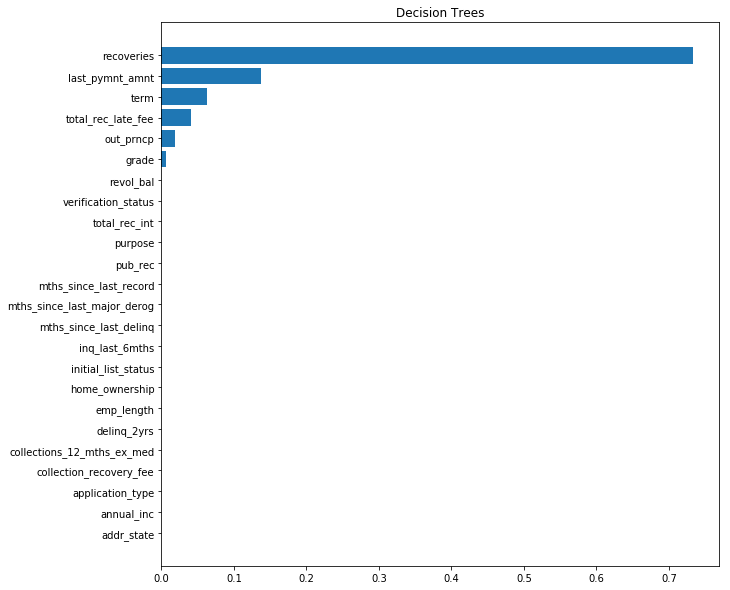

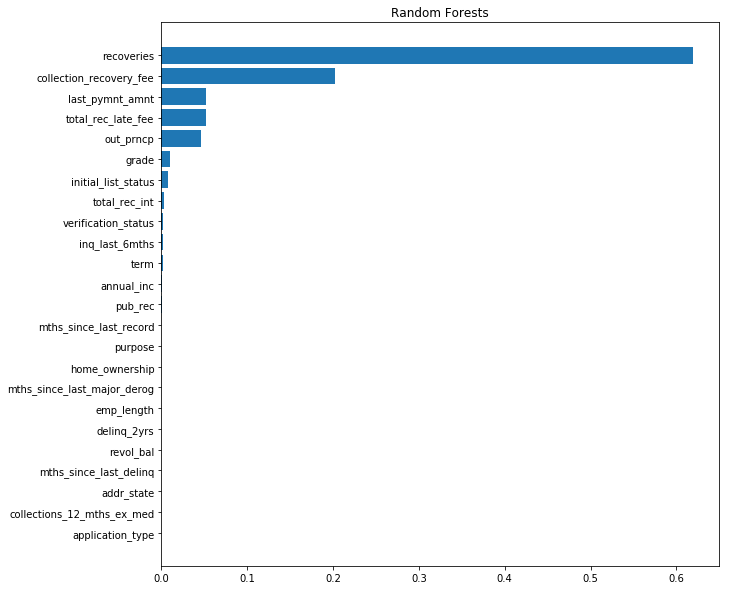

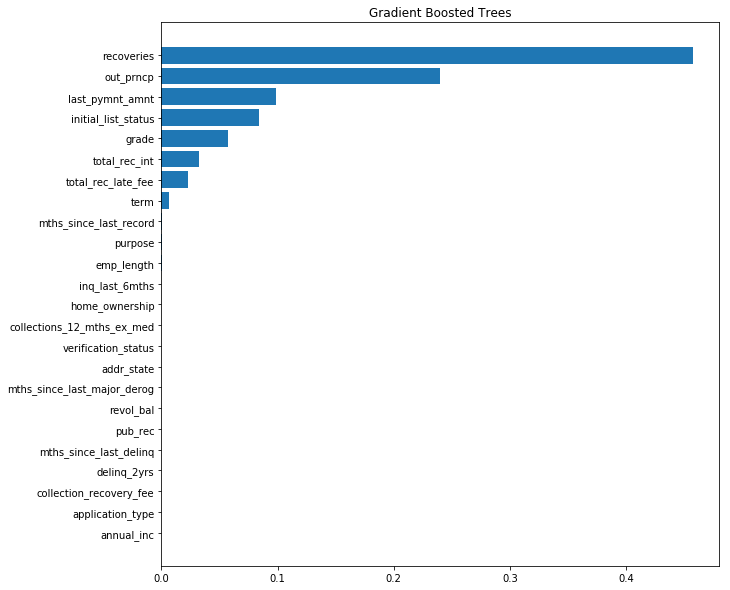

In [14]:
plt.figure(figsize=(50,20))
f_importances(dt_features, feature_list, 'Decision Trees')
f_importances(rf_features, feature_list, 'Random Forests')
f_importances(gbt_features, feature_list, 'Gradient Boosted Trees')

Now we stack the models. To do this need to use out-of-fold predictions. To save memory and for cleanliness, we store the OOF predictions in a separate csv file after we convert them to pandas dataframes for easier manipulation.

In [ ]:
# This is to combine dataframes
from functools import reduce  # For Python 3.x
from pyspark.sql import DataFrame

def unionAll(*dfs):
    return reduce(DataFrame.unionAll, dfs)

# This is for generating OOF training sets
from itertools import combinations

# first split training set into k-folds
training_splits = trainingData.randomSplit([1.0, 1.0, 1.0], 1234)

# generate list of training folds
fold_training = []
for folds in combinations([2,1,0], 2):
    fold_training.append(unionAll(training_splits[folds[0]], training_splits[folds[1]]))

In [ ]:
# OOF function that takes the clf and the training_splits list as inputs
# and outputs the OOF predictions in a pandas dataframe

def oof(clf, fold_training, training_splits, testData):
    # fit k-1 folds on 1st stage model and predict on kth fold for all folds
    fold_prediction = []
    test_prediction = []
    for i in range(0, 3):
        model = clf.fit(fold_training[i])
        fold_prediction.append(model.transform(training_splits[i]).select(['loan_status', 'prediction']).toPandas())
        test_prediction.append(model.transform(testData).select('prediction').toPandas())
    
    # we now have a list of pandas dataframes which we will concat and average (for test set)
    layer2_training = pd.concat(fold_prediction)
    layer2_test_predictions = pd.concat(test_prediction, axis=1).mean(axis=1)
    test_loans = testData.select('loan_status').toPandas()
    layer2_test = pd.concat([test_loans, layer2_test_predictions], axis=1)
    
    return layer2_training, layer2_test

In [ ]:
lr_layer2_training, lr_layer2_test = oof(lr, fold_training, training_splits, testData)
print('Logistic Regression OOF predictions complete.')

gbt_layer2_training, gbt_layer2_test = oof(gbt, fold_training, training_splits, testData)
print('Gradient-Boosted OOF predictions complete.')

lsvc_layer2_training, lsvc_layer2_test = oof(lsvc, fold_training, training_splits, testData)
print('Linear SVC OOF predictions complete.')

In [ ]:
# concat them all
layer2_training = pd.concat([lr_layer2_training, gbt_layer2_training, lsvc_layer2_training], axis=1)
layer2_test = pd.concat([lr_layer2_test, gbt_layer2_test, lsvc_layer2_test], axis=1)

# send to csv
layer2_training.to_csv('data/stacking/layer2_training.csv')
print('Layer 2 training set csv written.')

layer2_test.to_csv('data/stacking/layer2_test.csv')
print('Layer 2 test set csv written.')

In [ ]:
# layer2 into pyspark dataframes again (remove index column again and clean names/filter)
l2_train_df = spark.read.csv("data/stacking/layer2_training.csv",inferSchema =True,header=True)
l2_train_df = l2_train_df.drop('_c0')
l2_train_df = l2_train_df.select(col('loan_status1').alias('loan_status'), col('prediction2').alias('feature1'),\
                                col('prediction4').alias('feature2'), col('prediction6').alias('feature3'))
l2_train_df.show()

l2_test_df = spark.read.csv("data/stacking/layer2_test.csv",inferSchema =True,header=True)
l2_test_df = l2_test_df.drop('_c0')
l2_test_df = l2_test_df.select(col('loan_status1').alias('loan_status'), col('02').alias('feature1'),\
                               col('04').alias('feature2'), col('06').alias('feature3'))
l2_test_df.show()

In [ ]:
# Vector assembler again
ignore = ['loan_status']
assembler = VectorAssembler(
    inputCols=[x for x in l2_train_df.columns if x not in ignore],
    outputCol='features')

train_df = assembler.transform(l2_train_df)
train_df = train_df.select(['loan_status','features'])

test_df = assembler.transform(l2_test_df)
test_df = test_df.select(['loan_status','features'])

In [ ]:
# Data is too Sparse, need UDF to convert to dense vector to avoid empty vectors
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.ml.linalg import SparseVector, DenseVector

def sparse_to_array(v):
    v = DenseVector(v)
    new_array = list([float(x) for x in v])
    return new_array

sparse_to_array_udf = F.udf(sparse_to_array, T.ArrayType(T.FloatType()))

train_df = train_df.withColumn('features_array', sparse_to_array_udf('features'))
train_df = train_df.select('loan_status', col('features_array').alias('features'))
train_df.show()

test_df = test_df.withColumn('features_array', sparse_to_array_udf('features'))
test_df = test_df.select('loan_status', col('features_array').alias('features'))
test_df.show()

In [ ]:
mlp_model = mlp.fit(train_df)
print('Multi-layer Perceptron training complete')